# **FNN**
- Using data that was not annotated
- Training it on the unbalanced data
- Using avgpool
- 6 second window

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.ndimage
import pygame
import time
from scipy.signal import butter, filtfilt
import random

In [168]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/split_features_4s_all.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)

In [169]:
train_data = data['train'].copy()
val_data = data['val'].copy()

In [170]:
train_data

{'melspectrogram': array([[1.7294491e-05, 1.8239583e-05, 1.9485902e-05, ..., 5.1940111e-07,
         3.2287385e-08, 2.7940120e-08],
        [7.9314253e-07, 8.0714307e-07, 8.3096978e-07, ..., 1.3027967e-06,
         8.4759665e-07, 8.0172282e-07],
        [3.0612518e-06, 3.0607123e-06, 3.0592107e-06, ..., 6.0072955e-07,
         3.6999687e-08, 1.4126979e-08],
        ...,
        [1.0815166e-06, 1.0910663e-06, 1.1071655e-06, ..., 4.2367597e-07,
         1.3173792e-07, 1.2475495e-07],
        [2.1907644e-07, 2.7223422e-07, 3.6665881e-07, ..., 5.7446897e-07,
         1.8625977e-07, 1.7997159e-07],
        [2.4198832e-06, 2.6966893e-06, 3.1864115e-06, ..., 1.2659899e-05,
         2.3157411e-07, 2.2612821e-07]], dtype=float32),
 'mfcc': array([[-1.0000000e+00, -2.3626368e-01, -5.0428110e-01, ...,
          5.1737577e-03,  1.1148715e-02,  3.4610374e-04],
        [-1.0000000e+00, -2.4848318e-01, -4.7058651e-01, ...,
          2.9826174e-03,  9.7121680e-03, -5.3395964e-03],
        [-1.0000000e

In [171]:
train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

In [172]:
val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

# Shuffle Data

In [173]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [174]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [175]:
val_y, val_features = shuffle_data(val_labels, v_features)

In [176]:
display(train_y.shape)
display(train_y[:15])

(10981,)

array([ 0,  2, 12, 19,  1, 16, 12, 12,  2, 10,  1, 17, 17, 16,  5],
      dtype=int32)

In [177]:
for key in train_features.keys():
  display(key)
  display(train_features[key].shape)
  display(train_features[key][0])

'melspectrogram'

(10981, 60)

array([2.30762816e-05, 2.34475592e-05, 2.40821773e-05, 2.51011024e-05,
       2.66466941e-05, 2.92958284e-05, 3.51628805e-05, 6.25891989e-05,
       1.92321357e-04, 7.03408732e-04, 2.65689683e-03, 9.06991586e-03,
       2.57462058e-02, 3.97482254e-02, 6.07631765e-02, 8.05736035e-02,
       1.04595460e-01, 1.15686581e-01, 1.57870665e-01, 1.72645211e-01,
       1.86443135e-01, 1.28887072e-01, 8.85766745e-02, 7.87886903e-02,
       9.79994535e-02, 7.95486793e-02, 9.88657176e-02, 1.29356623e-01,
       1.11660235e-01, 1.01738557e-01, 8.50578472e-02, 9.85676572e-02,
       2.73807824e-01, 2.09708124e-01, 1.23314388e-01, 1.02081485e-01,
       3.67147297e-01, 4.48260367e-01, 2.47974992e-01, 2.81487495e-01,
       1.71025455e-01, 1.56875506e-01, 9.04699489e-02, 5.01980409e-02,
       1.14354856e-01, 1.35187045e-01, 8.44150558e-02, 7.01157376e-02,
       4.45818938e-02, 2.53626164e-02, 1.44096855e-02, 1.17013389e-02,
       1.02886660e-02, 6.78899651e-03, 3.07482062e-03, 6.01989741e-04,
      

'mfcc'

(10981, 20)

array([-1.        , -0.12701668, -0.33281082,  0.05484629, -0.08196964,
        0.03543973,  0.04314106,  0.0439313 , -0.01419341,  0.00685874,
       -0.01758255,  0.001139  , -0.00420982,  0.01086584, -0.00757602,
       -0.01450966, -0.00747609, -0.00540949,  0.03976055,  0.0034716 ],
      dtype=float32)

'chroma'

(10981, 12)

array([0.18950042, 0.2706272 , 0.45278975, 0.28500038, 0.22375982,
       0.26610336, 0.55544305, 0.43051782, 0.378617  , 0.37237042,
       0.28450966, 0.24387611], dtype=float32)

'rms'

(10981, 1)

array([0.02751933], dtype=float32)

In [178]:
display(val_y.shape)
display(val_y[:15])

(2928,)

array([ 1,  0,  3, 13, 15,  7,  0, 11, 17, 18, 10,  0,  1,  2,  2],
      dtype=int32)

In [179]:
for key in val_features.keys():
  display(key)
  display(val_features[key].shape)
  display(val_features[key][0])

'melspectrogram'

(2928, 60)

array([1.46651128e-05, 1.48556392e-05, 1.51859913e-05, 1.56665410e-05,
       1.63160948e-05, 1.78167320e-05, 1.98534417e-05, 4.05498686e-05,
       1.59472402e-04, 6.66950422e-04, 2.94189877e-03, 8.73562507e-03,
       2.48509813e-02, 5.62934652e-02, 1.06700696e-01, 1.37720481e-01,
       1.56773552e-01, 1.66458443e-01, 1.62727058e-01, 1.53277159e-01,
       1.42315477e-01, 1.38097569e-01, 1.40576839e-01, 1.23165958e-01,
       1.06688209e-01, 8.76584128e-02, 8.31917152e-02, 8.77315849e-02,
       9.44868550e-02, 8.88955891e-02, 7.43178725e-02, 8.85595381e-02,
       1.43550202e-01, 1.52272820e-01, 1.52132839e-01, 1.91071063e-01,
       2.06672847e-01, 1.97658002e-01, 2.46173069e-01, 2.55545259e-01,
       1.99123114e-01, 1.60002843e-01, 1.69800088e-01, 2.38350451e-01,
       2.02516481e-01, 2.13135630e-01, 9.99766588e-02, 1.05907999e-01,
       7.79003873e-02, 4.98168357e-02, 2.12974120e-02, 1.53250685e-02,
       6.21610088e-03, 3.42591107e-03, 1.57294865e-03, 2.99405801e-04,
      

'mfcc'

(2928, 20)

array([-1.0000000e+00, -1.1139911e-01, -5.3257447e-01, -5.3791061e-02,
       -2.8831151e-01,  2.4955302e-02, -5.6676064e-02,  9.0718277e-02,
       -4.6625780e-03,  8.0761328e-02,  3.1083501e-03,  3.8762629e-02,
       -7.4357318e-04,  9.6993856e-03, -3.5392428e-03, -1.5795501e-02,
        1.3769905e-02, -3.2622267e-02,  7.4427533e-03, -1.9556439e-02],
      dtype=float32)

'chroma'

(2928, 12)

array([0.3695338 , 0.37865743, 0.4104207 , 0.31655085, 0.3333765 ,
       0.34385303, 0.2945401 , 0.33566204, 0.36030295, 0.3360909 ,
       0.29794866, 0.2928751 ], dtype=float32)

'rms'

(2928, 1)

array([0.03157331], dtype=float32)

## **FNN Model**

In [180]:
def build_model(input_features,
                hidden_layers=[128,64,32],
                learning_rate=0.0005,
                output_units=20,
                dropout_rate=0.2):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(input_features,), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [181]:
def visualize(model_history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [182]:
train_results = {}
val_results = {}

### **With all the features**

In [183]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['rms'], train_features['melspectrogram']), axis=1)
training_features.shape

(10981, 93)

In [184]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['rms'], val_features['melspectrogram']), axis=1)

validation_features.shape

(2928, 93)

Fit the model with training data

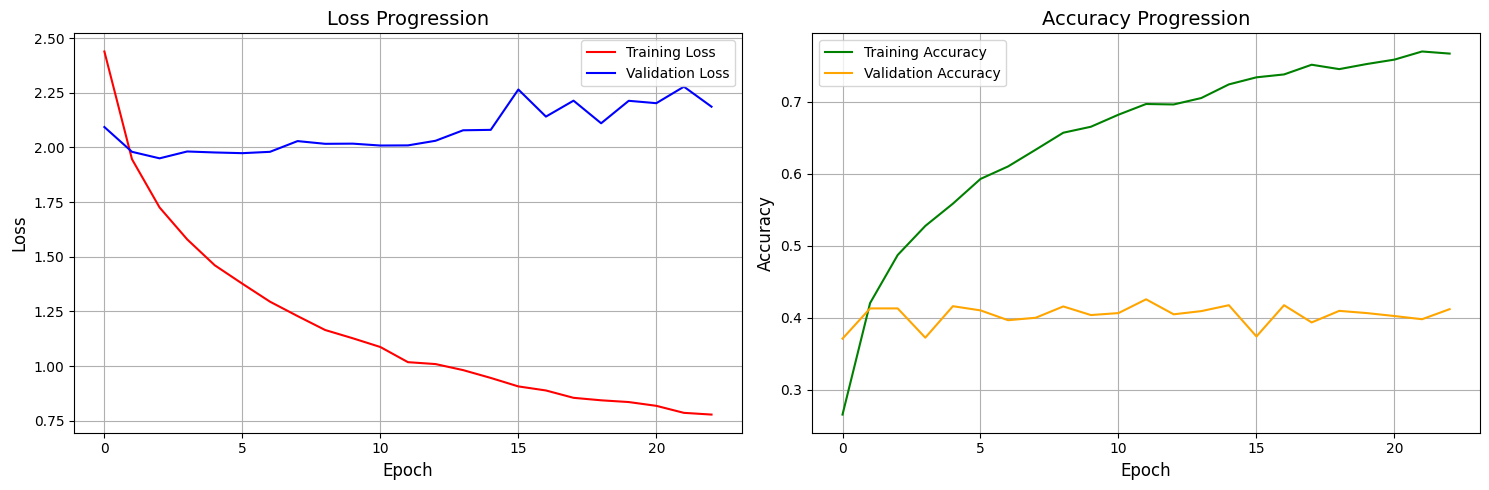

In [185]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_all_features_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [186]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6317 - loss: 1.3084
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4122 - loss: 1.9527


### **With MFCCs only**

In [187]:
training_features = train_features['mfcc']

training_features.shape

(10981, 20)

In [188]:
validation_features = val_features['mfcc']

validation_features.shape

(2928, 20)

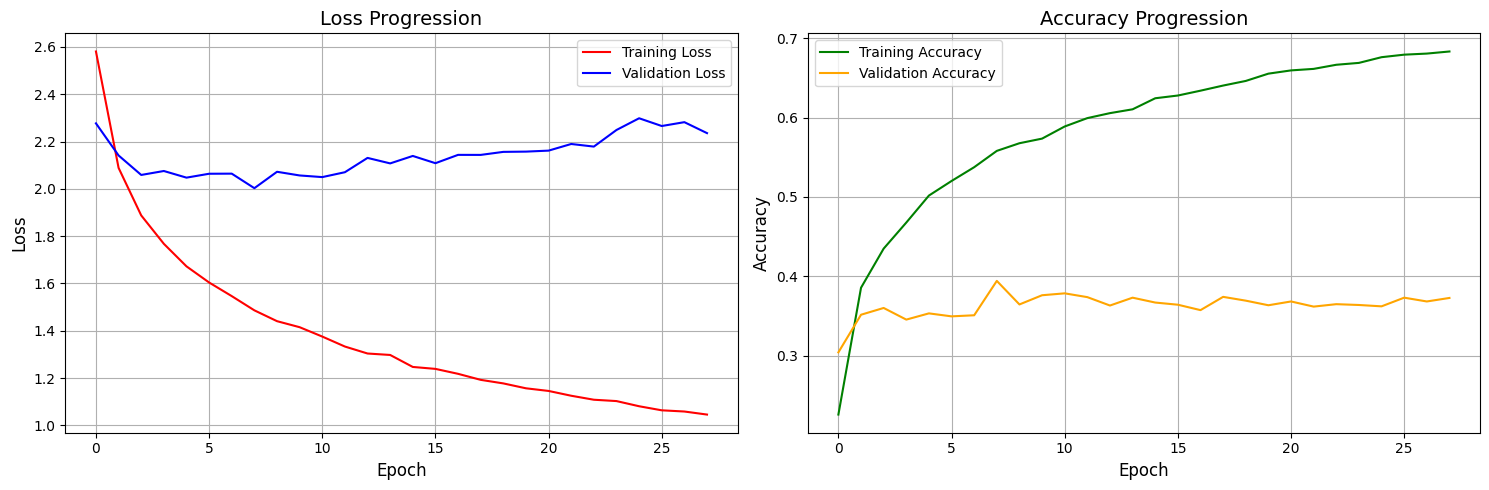

In [189]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [190]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6763 - loss: 1.1634
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3778 - loss: 2.0100


## **With MFCCs and Mel-Spectrogram**

In [191]:
training_features = np.concatenate((train_features['mfcc'], train_features['melspectrogram']), axis=1)

training_features.shape

(10981, 80)

In [192]:
validation_features = np.concatenate((val_features['mfcc'], val_features['melspectrogram']), axis=1)

validation_features.shape

(2928, 80)

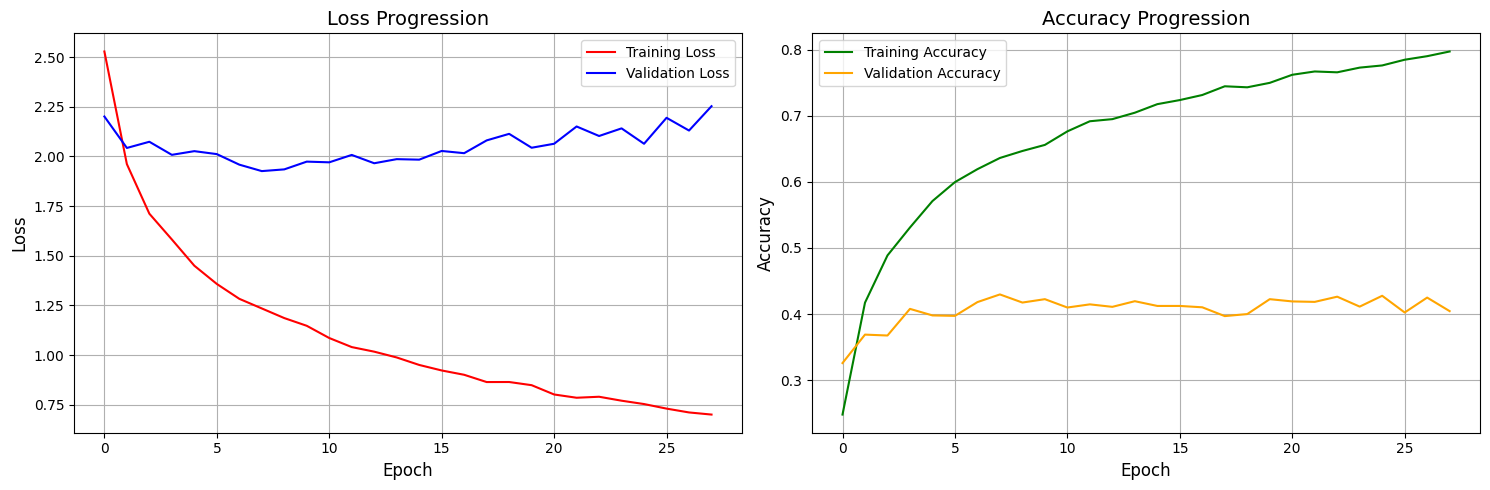

In [193]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_melspectrogram_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [194]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_melspectrogram'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_melspectrogram'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7679 - loss: 0.8473
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4257 - loss: 1.9095


## **With MFCCs and Chroma**

In [195]:
training_features = np.concatenate((train_features['mfcc'], train_features['chroma']), axis=1)

training_features.shape

(10981, 32)

In [196]:
validation_features = np.concatenate((val_features['mfcc'], val_features['chroma']), axis=1)

validation_features.shape

(2928, 32)

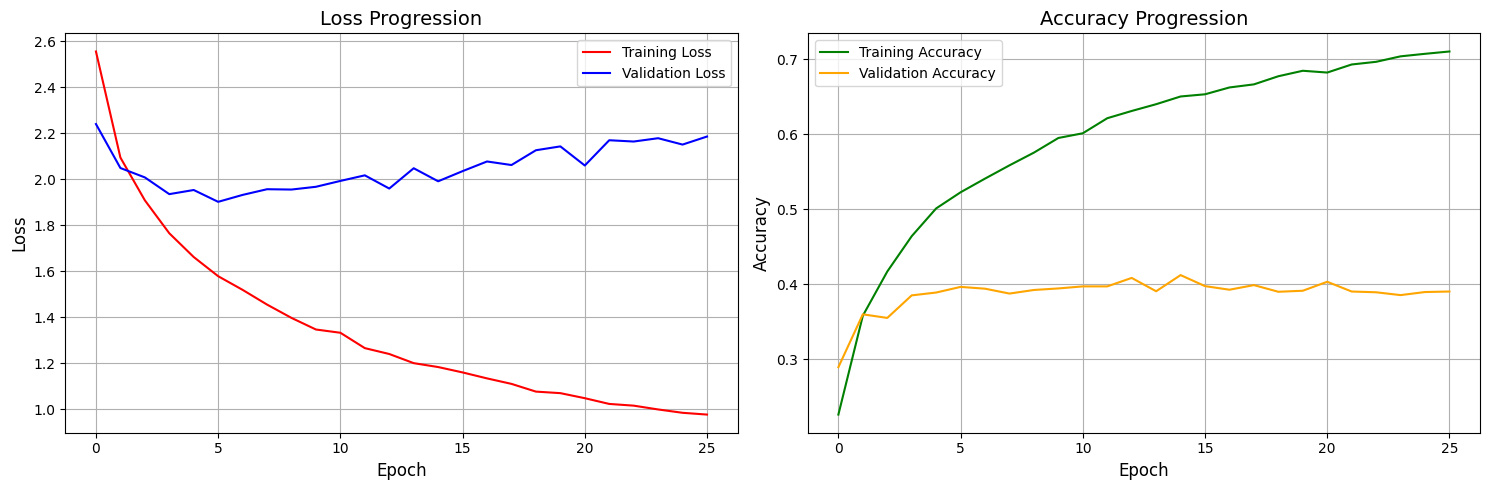

In [197]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_chroma_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [198]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_chroma'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_chroma'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6498 - loss: 1.2320
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3811 - loss: 1.9240


## **With MFCCs and RMS**

In [199]:
training_features = np.concatenate((train_features['mfcc'], train_features['rms']), axis=1)

training_features.shape

(10981, 21)

In [200]:
validation_features = np.concatenate((val_features['mfcc'], val_features['rms']), axis=1)

validation_features.shape

(2928, 21)

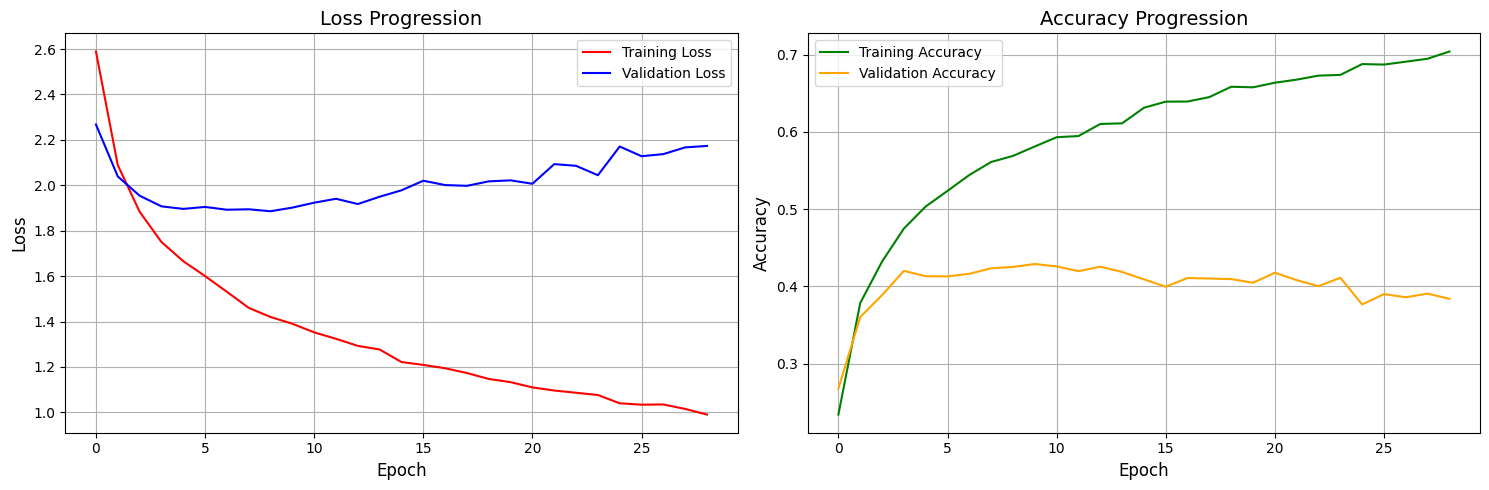

In [201]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_mfcc_rms_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [202]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_rms'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_rms'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6898 - loss: 1.0869
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4044 - loss: 1.8976


## **With Mel-Spectrogram, MFCCs, RMS**

In [203]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['rms'], train_features['mfcc']), axis=1)

training_features.shape

(10981, 81)

In [204]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['rms'], val_features['mfcc']), axis=1)

validation_features.shape

(2928, 81)

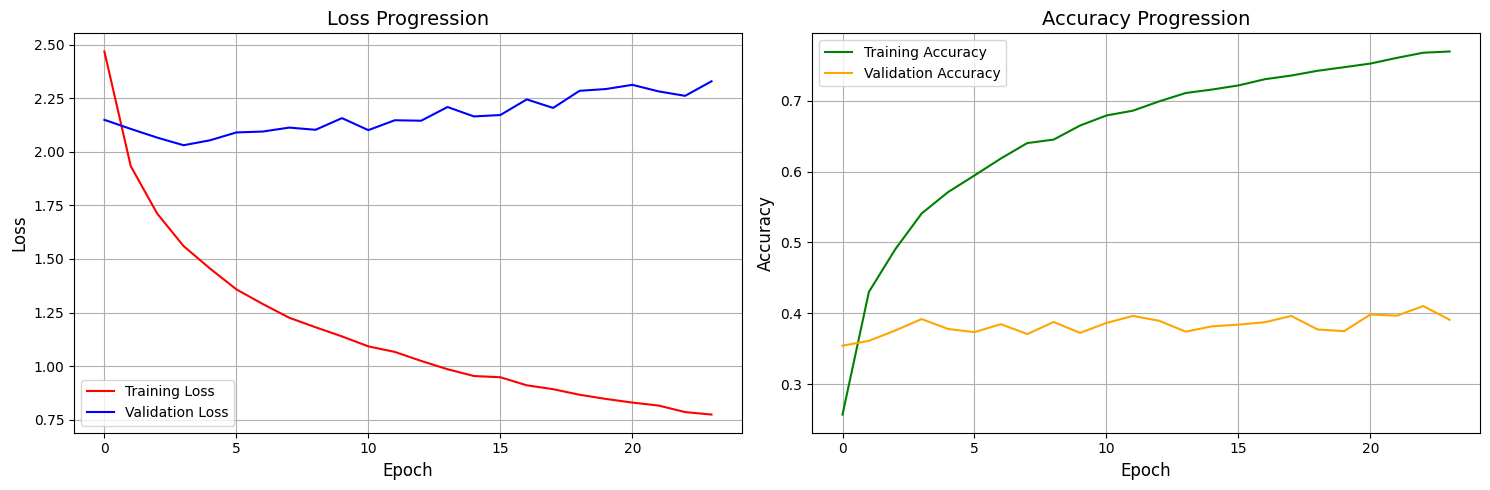

In [205]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_melspectrogram_rms_mfcc_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [206]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_rms_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_rms_mfcc'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6789 - loss: 1.1695
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3854 - loss: 2.0334


## **With Mel-Spectrogram, MFCCs, Chroma**

In [207]:
training_features = np.concatenate((train_features['melspectrogram'], train_features['chroma'], train_features['mfcc']), axis=1)

training_features.shape

(10981, 92)

In [208]:
validation_features = np.concatenate((val_features['melspectrogram'], val_features['chroma'], val_features['mfcc']), axis=1)

validation_features.shape

(2928, 92)

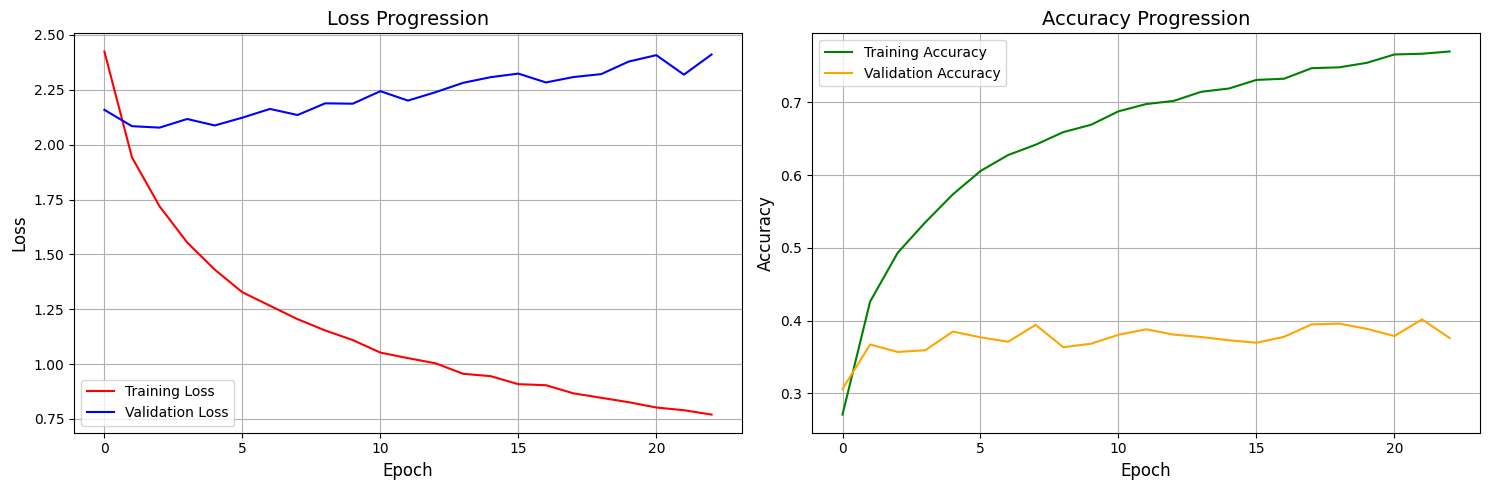

In [209]:
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

model = build_model(input_features=training_features.shape[1],
                    hidden_layers=[128,64,32])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("/content/drive/My Drive/Final-Year-Project/Dataset/Project-V4/feature-extraction/NotAnnotated/AveragePooled/6s_melspectrogram_chroma_mfcc_best_model.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    x=training_features,
    y=train_y,
    epochs=100,
    validation_data=(
        validation_features,
        val_y,
    ),
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, model_checkpoint]
)

visualize(history)

In [210]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_mfcc'] = model.evaluate(training_features, train_y)[-1]

val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_mfcc'] = model.evaluate(validation_features, val_y)[-1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6441 - loss: 1.2834
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3448 - loss: 2.0801


# Review results from all models

In [211]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,all_features,0.63,0.41
6,melspectrogram_chroma_mfcc,0.64,0.36
5,melspectrogram_rms_mfcc,0.67,0.39
1,mfcc,0.67,0.39
3,mfcc_chroma,0.64,0.40
2,mfcc_melspectrogram,0.76,0.43
4,mfcc_rms,0.68,0.43
